In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import io
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding
import seaborn as sns

# plt.rcParams.update({'font.size': 16})

# sns.set_theme()
import os

import sys
sys.path.append(sys.path[0][:-42])

import imp

from ikd import utils, core, evaluate, datasets, epca
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)
imp.reload(epca)

<module 'ikd.epca' from 'd:\\GT\\Lab\\ikd NeurIPS 2022\\src\\ikd\\epca.py'>

In [25]:
n_trials = 50
n_neurons = 50
backward = "sqrt"

if os.path.exists("exp5_py2mat.mat") is False:
    exp5_py2mat = []
    for trial in range(n_trials):
        rng = np.random.default_rng(trial)
        n, d_latent = 1000, 1
        z_true = datasets.generate_latent_from_prior(1, 1000, kernel='autoregressive', variance=9, length_scale=100, bound=6, seed=trial)
        kernel = "squared exponential"
        variance = 2
        length_scale = 1
        cov_true = utils.kernel_cov_generator(z_true, kernel=kernel, variance=variance, length_scale=length_scale)
        x = rng.multivariate_normal(mean=np.zeros(1000), cov=cov_true, size=n_neurons).T
        firing_rates = np.exp(x)
        spikes = rng.poisson(firing_rates).astype(float)
        spikes_dense = utils.backward(spikes, method=backward)

        z_pca = PCA(n_components=d_latent).fit_transform(spikes_dense)
        z_kernel_pca = KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(spikes_dense)
        z_le = SpectralEmbedding(n_components=d_latent).fit_transform(spikes_dense)
        z_epca = epca.exp_fam_pca(spikes, "poisson", r=d_latent)[3]

        cov_spikes = np.cov(spikes_dense)
        variance_spikes = 2 * np.mean(cov_spikes)
        cov_spikes_th = utils.filt_cov_samp(cov_spikes, variance_spikes)
        z_ikd = core.ikd(cov_spikes_th, d_latent, kernel=kernel, variance=variance_spikes, length_scale=1)[0]
        z_ikd_b = core.ikd_blockwise(cov_spikes_th, d_latent, kernel=kernel, variance=variance_spikes, length_scale=1, clique_th_or_d_observation=n_neurons, z_ref=z_le)

        sol = epca.exp_fam_pca(spikes.T, "poisson", r=spikes.shape[1])
        firing_rates_est = epca.wiener_filter(sol[0], spikes.T, "poisson").T
        x_est = utils.backward(firing_rates_est, method=backward)
        cov_est = np.cov(x_est)
        variance_est = 2 * np.mean(cov_est)
        cov_est_th = utils.filt_cov_samp(cov_est, variance_est)
        z_eikd = core.ikd(cov_est_th, d_latent, kernel=kernel, variance=variance_spikes, length_scale=1)[0]
        z_eikd_b = core.ikd_blockwise(cov_est_th, z_true.shape[1], kernel="squared exponential", variance=variance_est, length_scale=1, clique_th_or_d_observation=spikes.shape[0], z_ref=z_le)

        exp5_py2mat.append({"z_true": z_true, "spikes": spikes, "firing_rates": firing_rates, "firing_rates_est": firing_rates_est, 'z_pca': z_pca, 'z_kernel_pca': z_kernel_pca, 'z_le': z_le, "z_epca": z_epca, "z_ikd": z_ikd, 'z_ikd_b': z_ikd_b, 'z_eikd': z_eikd, 'z_eikd_b': z_eikd_b})
        print(trial)
    io.savemat("exp5_py2mat.mat", {"exp5_py2mat": exp5_py2mat})

In [26]:
n_trials = 50
result = np.zeros(n_trials)
df_list = []
name_list = ['pca', 'kernel_pca', 'le', 'epca', 'plds', 'ikd', 'ikd_b', 'eikd', 'eikd_b']
method_list = ['PCA', 'kernel PCA', 'Laplacian eigenmaps', '$e$PCA', 'PLDS', 'IKD', 'IKD-b', '$e$IKD', '$e$IKD-b']
for trial in range(n_trials):
    exp5_py2mat = io.loadmat(f"exp5_py2mat.mat")['exp5_py2mat']
    exp5_mat2py = io.loadmat(f"outputs/exp5_mat2py_{trial+1}.mat")['result']
    z_true = exp5_py2mat[0, trial]['z_true'][0, 0]
    df_list.append(pd.DataFrame({"R^2": list(map(lambda x: r2_score(z_true, utils.align(z_true, x)), [exp5_mat2py[i][0, 0]['init'][0, 0] for i in name_list] + [exp5_mat2py[i][0, 0]['pgplvm'][0, 0] for i in name_list])),
    "method": 2 * method_list,
    'type': len(method_list) * ['Initial'] + len(method_list) * ['PGPLVM'],
    'trial': 2 * len(method_list) * [trial]}))
df2 = pd.concat(df_list, ignore_index=True)
df2.loc[:, '$N$'] = 50
df2 = df2.rename(columns={'R^2': '$R^2$'})

In [27]:
# sns.boxplot(x='type', y="R^2", hue='method', data=df, showmeans=True, meanprops={"markerfacecolor": "white", "markeredgecolor": "blue"}).set(xlabel=None, ylabel='$R^2$')

In [28]:
n_neurons_list = [20, 50, 100, 500]
color_list = ['C0', 'C1', 'C2', 'C3', 'C5', 'C6', 'C7', 'C8']
backward = 'sqrt'
df = pd.concat([pd.melt(pd.read_csv(f"../exp4_Poisson_noisy_observations/outputs/{n_neurons}_{backward}.csv") , value_vars=["PCA", 'kernel PCA', 'Laplacian eigenmaps', "$e$PCA", "IKD", "IKD-b", "$e$IKD", "$e$IKD-b"], var_name="method", value_name="R^2").assign(n_neurons=n_neurons) for n_neurons in n_neurons_list], ignore_index=True)
df = df.rename(columns={'n_neurons': '$N$', 'R^2': '$R^2$'})

In [29]:
trial = 25
exp5_py2mat = io.loadmat(f"exp5_py2mat.mat")['exp5_py2mat']
exp5_mat2py = io.loadmat(f"outputs/exp5_mat2py_{trial+1}.mat")['result']
z_true = exp5_py2mat[0, trial]['z_true'][0, 0]

In [30]:
for i in [0, 1, 2, 3, 5, 6, 7, 8, 4]:
    plt.plot(utils.align(z_true, exp5_mat2py[name_list[i]][0, 0]['pgplvm'][0, 0])[:, 0], label=method_list[i], c=f'C{i}')
plt.plot(z_true[:, 0], 'k--', label='True')
handles, labels = plt.gca().get_legend_handles_labels()
plt.close()

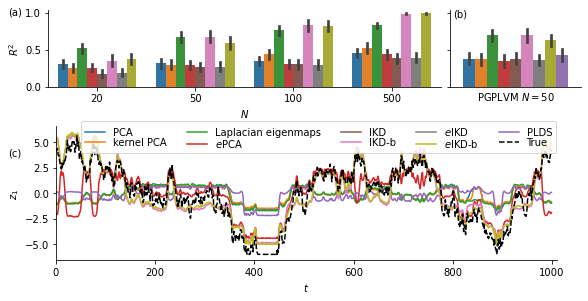

In [31]:
fig = plt.figure(figsize=(8, 4), constrained_layout=True)
subfigs = fig.subfigures(2, 1, height_ratios=[2, 3])
axs = subfigs[0].subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
ax = sns.barplot(x="$N$", y='$R^2$', hue="method", data=df, ax=axs[0], palette=color_list)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set(xlabel='$N$', ylabel='$R^2$')
ax.legend_.remove()
ax = sns.barplot(x='$N$', y="$R^2$", hue='method', data=df2[df2.type=='PGPLVM'], ax=axs[1], palette=['C0', 'C1', 'C2', 'C3', 'C5', 'C6', 'C7', 'C8', 'C4'], hue_order=['PCA', 'kernel PCA', 'Laplacian eigenmaps', '$e$PCA', 'IKD', 'IKD-b', '$e$IKD', '$e$IKD-b', 'PLDS'])
ax.legend_.remove()
ax.set(xlabel='PGPLVM $N=50$', ylabel=None)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.text(-0.48, 0.94, '(b)')

ax = subfigs[1].add_subplot(1, 1, 1)
z_aligned = {}
for i in [0, 1, 2, 3, 4, 6, 8]:
    ax.plot(utils.align(z_true, exp5_mat2py[name_list[i]][0, 0]['pgplvm'][0, 0])[:, 0], label=method_list[i], c=f'C{i}')
ax.plot(z_true[:, 0], 'k--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, 1010])
ax.legend(handles, labels, loc=(0.05, 0.8), ncol=5, fontsize=10, labelspacing=0)
ax.set_xlabel('$t$')
ax.set_ylabel('$z_1$')

fig.text(0.0, 0.97, '(a)')
fig.text(0.0, 0.48, '(c)')

plt.savefig('initialization.pdf', bbox_inches='tight')